# Image Classification
In this project, you'll classify images from the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).  The dataset consists of airplanes, dogs, cats, and other objects. You'll preprocess the images, then train a convolutional neural network on all the samples. The images need to be normalized and the labels need to be one-hot encoded.  You'll get to apply what you learned and build a convolutional, max pooling, dropout, and fully connected layers.  At the end, you'll get to see your neural network's predictions on the sample images.
## Get the Data
Run the following cell to download the [CIFAR-10 dataset for python](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz).

## Data
CIFAR-10  is an established computer-vision dataset used for object recognition. It is a subset of the 80 million tiny images dataset and consists of 60,000 32x32 color images containing one of 10 object classes, with 6000 images per class. It was collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton.

Let's get the data by running the following function

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('cifar-10-python.tar.gz'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            'cifar-10-python.tar.gz',
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()


CIFAR-10 Dataset: 171MB [00:12, 14.1MB/s]                              


## Explore the Data
The dataset is broken into batches to prevent your machine from running out of memory.  The CIFAR-10 dataset consists of 5 batches, named `data_batch_1`, `data_batch_2`, etc.. Each batch contains the labels and images that are one of the following:
* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

Understanding a dataset is part of making predictions on the data.  Play around with the code cell below by changing the `batch_id` and `sample_id`. The `batch_id` is the id for a batch (1-5). The `sample_id` is the id for a image and label pair in the batch.

Ask yourself "What are all possible labels?", "What is the range of values for the image data?", "Are the labels in order or random?".  Answers to questions like these will help you preprocess the data and end up with better predictions.

## The following are some helper functions students can use in their code

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer


def _load_label_names():
    """
    Load the label names from file
    """
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


def load_cfar10_batch(cifar10_dataset_folder_path, batch_id):
    """
    Load a batch of the dataset
    """
    with open(cifar10_dataset_folder_path + '/data_batch_' + str(batch_id), mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # total_features*RGB*H*W
    features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1) #(len, 32, 32, 3)
    labels = batch['labels']
    
#     print(batch['data'])
#     print("-"*80)
#     print(batch['data'].reshape((len(batch['data']), 3, 32, 32)))
#     print("-"*80)
#     print(features)
#     print("-"*80)
#     print(labels)

    return features, labels


def display_stats(cifar10_dataset_folder_path, batch_id, sample_id):
    """
    Display Stats of the the dataset
    """
    batch_ids = list(range(1, 6))

    if batch_id not in batch_ids:
        print('Batch Id out of Range. Possible Batch Ids: {}'.format(batch_ids))
        return None

    features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_id)

    if not (0 <= sample_id < len(features)):
        print('{} samples in batch {}.  {} is out of range.'.format(len(features), batch_id, sample_id))
        return None

    print('\nStats of batch {}:'.format(batch_id))
    print('Samples: {}'.format(len(features)))
    print('Label Counts: {}'.format(dict(zip(*np.unique(labels, return_counts=True)))))
    print('First 20 Labels: {}'.format(labels[:20]))

    sample_image = features[sample_id]
    sample_label = labels[sample_id]
    label_names = _load_label_names()

    print('\nExample of Image {}:'.format(sample_id))
    print('Image - Min Value: {} Max Value: {}'.format(sample_image.min(), sample_image.max()))
    print('Image - Shape: {}'.format(sample_image.shape))
    print('Label - Label Id: {} Name: {}'.format(sample_label, label_names[sample_label]))
    plt.axis('off')
    plt.imshow(sample_image)


def _preprocess_and_save(normalize, one_hot_encode, features, labels, filename):
    """
    Preprocess data and save it to file
    """
    features = normalize(features)
    labels = one_hot_encode(labels)

    pickle.dump((features, labels), open(filename, 'wb'))


def preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode):
    """
    Preprocess Training and Validation Data
    """
    n_batches = 5
    valid_features = []
    valid_labels = []

    for batch_i in range(1, n_batches + 1):
        features, labels = load_cfar10_batch(cifar10_dataset_folder_path, batch_i)
        validation_count = int(len(features) * 0.1) #10%

        # Prprocess and save a batch of training data
        _preprocess_and_save(
            normalize,
            one_hot_encode,
            features[:-validation_count],
            labels[:-validation_count],
            'preprocess_batch_' + str(batch_i) + '.p')

        # Use a portion of training batch for validation
        valid_features.extend(features[-validation_count:])
        valid_labels.extend(labels[-validation_count:])

    # Preprocess and Save all validation data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(valid_features),
        np.array(valid_labels),
        'preprocess_validation.p')

    with open(cifar10_dataset_folder_path + '/test_batch', mode='rb') as file:
        batch = pickle.load(file, encoding='latin1')

    # load the test data
    test_features = batch['data'].reshape((len(batch['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
    test_labels = batch['labels']

    # Preprocess and Save all test data
    _preprocess_and_save(
        normalize,
        one_hot_encode,
        np.array(test_features),
        np.array(test_labels),
        'preprocess_testing.p')


def batch_features_labels(features, labels, batch_size):
    """
    Split features and labels into batches
    """
    for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]


def load_preprocess_training_batch(batch_id, batch_size):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocess_batch_' + str(batch_id) + '.p'
    features, labels = pickle.load(open(filename, mode='rb'))

    # Return the training data in batches of size <batch_size> or less
    return batch_features_labels(features, labels, batch_size)


def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = _load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=4, ncols=2)
    fig.tight_layout()
    fig.suptitle('Softmax Predictions', fontsize=20, y=1.1)

    n_predictions = 5
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]

        axies[image_i][0].imshow(feature*255)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])



Stats of batch 3:
Samples: 10000
Label Counts: {0: 994, 1: 1042, 2: 965, 3: 997, 4: 990, 5: 1029, 6: 978, 7: 1015, 8: 961, 9: 1029}
First 20 Labels: [8, 5, 0, 6, 9, 2, 8, 3, 6, 2, 7, 4, 6, 9, 0, 0, 7, 3, 7, 2]

Example of Image 5:
Image - Min Value: 9 Max Value: 255
Image - Shape: (32, 32, 3)
Label - Label Id: 2 Name: bird


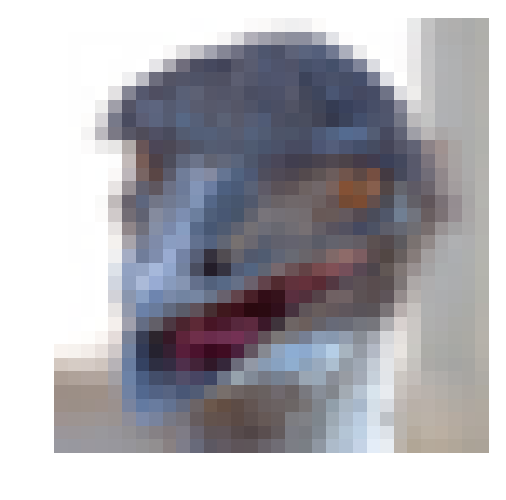

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

# Explore the dataset
batch_id = 3 #1-5
sample_id = 5 #1-10,000
display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

# Solution 

## Implement Preprocess Functions
### Normalize

In [4]:
import numpy as np
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    x = np.array(x)
    x_max = np.max(x)
    x_min = np.min(x)
    output = (x - x_min)/(x_max - x_min)
    return output


### One-hot encode


In [5]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(range(10))


def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    #print(lb.transform(x))
    return lb.transform(x) #0-9


## Preprocess all the data and save it


In [6]:
preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

In [7]:
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

In [8]:
valid_features[0], valid_labels[0]

(array([[[0.54901961, 0.49019608, 0.45098039],
         [0.57254902, 0.50980392, 0.47843137],
         [0.56078431, 0.49803922, 0.47843137],
         ...,
         [0.66666667, 0.56862745, 0.51372549],
         [0.69019608, 0.58823529, 0.5254902 ],
         [0.66666667, 0.57647059, 0.52156863]],
 
        [[0.4745098 , 0.42352941, 0.50588235],
         [0.50980392, 0.4627451 , 0.54509804],
         [0.5254902 , 0.4745098 , 0.56078431],
         ...,
         [0.63921569, 0.55294118, 0.61568627],
         [0.66666667, 0.57254902, 0.63137255],
         [0.66666667, 0.58039216, 0.63137255]],
 
        [[0.59607843, 0.54509804, 0.68235294],
         [0.61568627, 0.56862745, 0.70196078],
         [0.60784314, 0.56078431, 0.68627451],
         ...,
         [0.69411765, 0.60392157, 0.75686275],
         [0.70980392, 0.61176471, 0.76078431],
         [0.71764706, 0.62745098, 0.76078431]],
 
        ...,
 
        [[0.49019608, 0.43137255, 0.4       ],
         [0.50588235, 0.43921569, 0.40392

## Build the network

### Input


In [9]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a bach of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    return tf.placeholder(tf.float32, shape = (None, image_shape[0], image_shape[1], image_shape[2]), name = 'x')


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    return tf.placeholder(tf.float32, shape = (None, n_classes), name = 'y')


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    return tf.placeholder(tf.float32, shape = (None), name = 'keep_prob')


tf.reset_default_graph()


/usr/local/anaconda/python3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Convolution and Max Pooling Layer


In [10]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    shape_of_x_tensor = x_tensor.get_shape().as_list()
    F_W = tf.Variable(tf.truncated_normal([conv_ksize[0] ,conv_ksize[1] ,shape_of_x_tensor[-1] ,conv_num_outputs] 
                                          ,dtype=tf.float32, stddev=0.2))
    F_b = tf.Variable(tf.zeros([conv_num_outputs]  ,dtype=tf.float32))
    
    strides_conv = [1, conv_strides[0], conv_strides[1], 1]
    padding = 'SAME'
    
    output = tf.nn.conv2d(x_tensor, F_W, strides_conv, padding)
    output = tf.nn.bias_add(output, F_b)
    
    output = tf.nn.relu(output)
    

    ksize_maxpool = [1, pool_ksize[0], pool_ksize[1], 1]
    strides_maxpool = [1, pool_strides[0], pool_strides[1], 1]
    output = tf.nn.max_pool(output, ksize_maxpool, strides_maxpool, padding)
    
    return output 


#https://stackoverflow.com/questions/34642595/tensorflow-strides-argument

### Flatten Layer


In [11]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    # TODO: Implement Function
    shape = x_tensor.get_shape().as_list()
    flat_dim = shape[1]*shape[2]*shape[3]
    output = tf.reshape(x_tensor, [-1, flat_dim])
    return output


### Fully-Connected Layer


In [12]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    shape = x_tensor.get_shape().as_list()
    weights= tf.Variable(tf.truncated_normal([shape[1], num_outputs] ,dtype=tf.float32, stddev=0.2))
    biases = tf.Variable(tf.zeros([num_outputs]  ,dtype=tf.float32))
    
    out = tf.add(tf.matmul(x_tensor, weights), biases)
    out = tf.nn.relu(out)
    return out


### Output Layer


In [13]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    shape = x_tensor.get_shape().as_list()
    weights= tf.Variable(tf.truncated_normal([shape[1], num_outputs] ,dtype=tf.float32, stddev=0.2))
    biases = tf.Variable(tf.zeros([num_outputs]  ,dtype=tf.float32))
    out = tf.add(tf.matmul(x_tensor, weights), biases)
    return out


### Create Convolutional Model


In [14]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """

    out = conv2d_maxpool(x, conv_num_outputs = 16, conv_ksize = (3,3), conv_strides = (1,1), pool_ksize=(2,2), pool_strides=(2,2))
    out = conv2d_maxpool(out, conv_num_outputs = 32, conv_ksize = (3,3), conv_strides = (1,1), pool_ksize=(2,2), pool_strides=(2,2))
    out = conv2d_maxpool(out, conv_num_outputs = 64, conv_ksize = (3,3), conv_strides = (1,1), pool_ksize=(2,2), pool_strides=(2,2))

    # Function Definition from Above:
    out = flatten(out)
    
    

    out = fully_conn(out, num_outputs = 64)
    out = tf.nn.dropout(out, keep_prob)
    out = fully_conn(out, num_outputs = 32)
    out = tf.nn.dropout(out, keep_prob)
    out = fully_conn(out, num_outputs = 16)
    #    Set this to the number of classes
    # Function Definition from Above:
    out = output(out, num_outputs = 10)

    return out


##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')



Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



## Train the Neural Network
### Single Optimization


In [15]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    session.run(optimizer, feed_dict={x:feature_batch, y:label_batch,keep_prob:keep_probability})


### Show Stats


In [16]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    valid_acc = sess.run(accuracy, feed_dict={
                x: valid_features,
                y: valid_labels,
                keep_prob: 1.})
    train_acc = sess.run(accuracy, feed_dict={
                x: feature_batch,
                y: label_batch,
                keep_prob: 1.})
    train_cost = sess.run(cost, feed_dict={
                x: feature_batch,
                y: label_batch,
                keep_prob: 1.})
    print('Cost {::>8.5f}, Accuracy on Training {:.4f} -'
                  'Validation Accuracy: {:.4f}'.format(
                train_cost,
                train_acc,
                valid_acc))

### Hyperparameters


In [17]:
epochs = 50
batch_size = 256
keep_probability = 0.6

### Train on a Single CIFAR-10 Batch


In [18]:
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  Cost :2.27491, Accuracy on Training 0.2000 -Validation Accuracy: 0.1648
Epoch  2, CIFAR-10 Batch 1:  Cost :2.24383, Accuracy on Training 0.2250 -Validation Accuracy: 0.1872
Epoch  3, CIFAR-10 Batch 1:  Cost :2.15063, Accuracy on Training 0.3500 -Validation Accuracy: 0.2314
Epoch  4, CIFAR-10 Batch 1:  Cost :1.99705, Accuracy on Training 0.3500 -Validation Accuracy: 0.2508
Epoch  5, CIFAR-10 Batch 1:  Cost :1.92219, Accuracy on Training 0.3250 -Validation Accuracy: 0.2910
Epoch  6, CIFAR-10 Batch 1:  Cost :1.87706, Accuracy on Training 0.3500 -Validation Accuracy: 0.2934
Epoch  7, CIFAR-10 Batch 1:  Cost :1.79448, Accuracy on Training 0.3750 -Validation Accuracy: 0.3090
Epoch  8, CIFAR-10 Batch 1:  Cost :1.79433, Accuracy on Training 0.4500 -Validation Accuracy: 0.3160
Epoch  9, CIFAR-10 Batch 1:  Cost :1.70788, Accuracy on Training 0.5000 -Validation Accuracy: 0.3216
Epoch 10, CIFAR-10 Batch 1:  Cost :1.64427, Accu

### Fully Train the Model


In [19]:
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Cost :2.29940, Accuracy on Training 0.1000 -Validation Accuracy: 0.1018
Epoch  1, CIFAR-10 Batch 2:  Cost :2.27721, Accuracy on Training 0.1500 -Validation Accuracy: 0.1410
Epoch  1, CIFAR-10 Batch 3:  Cost :2.26827, Accuracy on Training 0.3000 -Validation Accuracy: 0.1576
Epoch  1, CIFAR-10 Batch 4:  Cost :2.23117, Accuracy on Training 0.1750 -Validation Accuracy: 0.1830
Epoch  1, CIFAR-10 Batch 5:  Cost :2.13809, Accuracy on Training 0.3000 -Validation Accuracy: 0.2382
Epoch  2, CIFAR-10 Batch 1:  Cost :2.20258, Accuracy on Training 0.2000 -Validation Accuracy: 0.2374
Epoch  2, CIFAR-10 Batch 2:  Cost :1.90722, Accuracy on Training 0.3250 -Validation Accuracy: 0.2672
Epoch  2, CIFAR-10 Batch 3:  Cost :1.67303, Accuracy on Training 0.5250 -Validation Accuracy: 0.2984
Epoch  2, CIFAR-10 Batch 4:  Cost :1.83213, Accuracy on Training 0.3250 -Validation Accuracy: 0.3128
Epoch  2, CIFAR-10 Batch 5:  Cost :1.72676, Accuracy on Training 0.4000 -Valida

Epoch 17, CIFAR-10 Batch 2:  Cost :0.79248, Accuracy on Training 0.6750 -Validation Accuracy: 0.6138
Epoch 17, CIFAR-10 Batch 3:  Cost :0.68551, Accuracy on Training 0.7500 -Validation Accuracy: 0.5944
Epoch 17, CIFAR-10 Batch 4:  Cost :0.75947, Accuracy on Training 0.7750 -Validation Accuracy: 0.6032
Epoch 17, CIFAR-10 Batch 5:  Cost :0.77048, Accuracy on Training 0.7000 -Validation Accuracy: 0.6060
Epoch 18, CIFAR-10 Batch 1:  Cost :0.73106, Accuracy on Training 0.7500 -Validation Accuracy: 0.6116
Epoch 18, CIFAR-10 Batch 2:  Cost :0.81003, Accuracy on Training 0.6500 -Validation Accuracy: 0.6094
Epoch 18, CIFAR-10 Batch 3:  Cost :0.64991, Accuracy on Training 0.7000 -Validation Accuracy: 0.6006
Epoch 18, CIFAR-10 Batch 4:  Cost :0.68728, Accuracy on Training 0.8250 -Validation Accuracy: 0.6126
Epoch 18, CIFAR-10 Batch 5:  Cost :0.74991, Accuracy on Training 0.7750 -Validation Accuracy: 0.6196
Epoch 19, CIFAR-10 Batch 1:  Cost :0.70866, Accuracy on Training 0.7500 -Validation Accurac

Epoch 33, CIFAR-10 Batch 3:  Cost :0.37412, Accuracy on Training 0.9250 -Validation Accuracy: 0.6612
Epoch 33, CIFAR-10 Batch 4:  Cost :0.40532, Accuracy on Training 0.9500 -Validation Accuracy: 0.6652
Epoch 33, CIFAR-10 Batch 5:  Cost :0.43937, Accuracy on Training 0.9250 -Validation Accuracy: 0.6594
Epoch 34, CIFAR-10 Batch 1:  Cost :0.46078, Accuracy on Training 0.8250 -Validation Accuracy: 0.6598
Epoch 34, CIFAR-10 Batch 2:  Cost :0.44517, Accuracy on Training 0.8250 -Validation Accuracy: 0.6500
Epoch 34, CIFAR-10 Batch 3:  Cost :0.40497, Accuracy on Training 0.9000 -Validation Accuracy: 0.6652
Epoch 34, CIFAR-10 Batch 4:  Cost :0.45055, Accuracy on Training 0.9250 -Validation Accuracy: 0.6598
Epoch 34, CIFAR-10 Batch 5:  Cost :0.43564, Accuracy on Training 0.9250 -Validation Accuracy: 0.6642
Epoch 35, CIFAR-10 Batch 1:  Cost :0.45283, Accuracy on Training 0.8000 -Validation Accuracy: 0.6628
Epoch 35, CIFAR-10 Batch 2:  Cost :0.39377, Accuracy on Training 0.8750 -Validation Accurac

Epoch 49, CIFAR-10 Batch 4:  Cost :0.30056, Accuracy on Training 0.9750 -Validation Accuracy: 0.6616
Epoch 49, CIFAR-10 Batch 5:  Cost :0.29838, Accuracy on Training 0.9500 -Validation Accuracy: 0.6760
Epoch 50, CIFAR-10 Batch 1:  Cost :0.39035, Accuracy on Training 0.8750 -Validation Accuracy: 0.6510
Epoch 50, CIFAR-10 Batch 2:  Cost :0.35161, Accuracy on Training 0.8750 -Validation Accuracy: 0.6560
Epoch 50, CIFAR-10 Batch 3:  Cost :0.27711, Accuracy on Training 0.9750 -Validation Accuracy: 0.6782
Epoch 50, CIFAR-10 Batch 4:  Cost :0.28375, Accuracy on Training 0.9750 -Validation Accuracy: 0.6728
Epoch 50, CIFAR-10 Batch 5:  Cost :0.28954, Accuracy on Training 0.9500 -Validation Accuracy: 0.6760


## Test Model


INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.67255859375



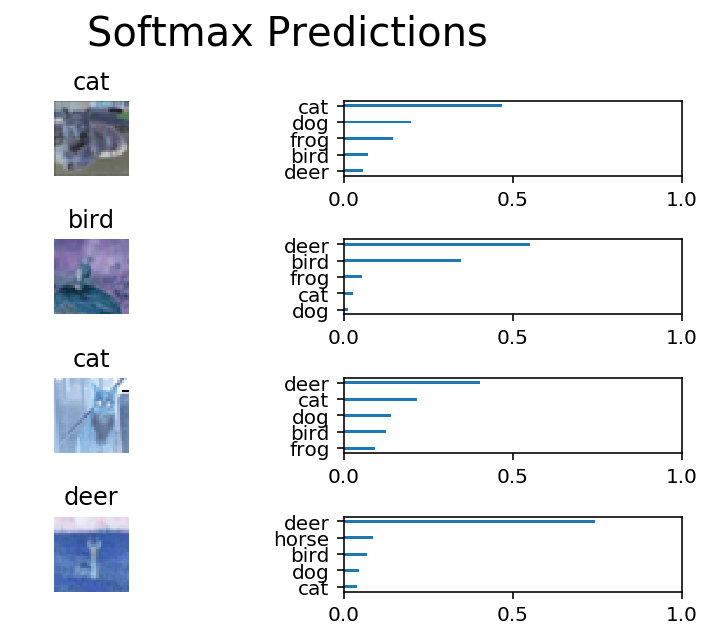

In [20]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 5

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_testing.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for train_feature_batch, train_label_batch in batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: train_feature_batch, loaded_y: train_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()